# Prognoza Nominalizare Consum Zilnic Gaz 

Avand in vedere obligatia alimentarii cu gaz a consumatorilor din portofoliu, sarcina ce are la baza gestionarea cat mai exacta a volumului de gaz care se reflecta in dinamica achizitionarii gazului respectiv, este necesara efectuarea unei prognoze de consum.

Considerand lipsa de unelte pentru efectuarea prognozei (se foloseste doar Excel ca tool, respectiv matematica elementara) respectiv timpul si eroarea relativ mari, m-am decis sa construiesc un proiect de "Machine Learning", pentru a rezolva intr-un mod eficient si modern aceasta poblema.

## Cum a fost gandit proiectul?

Baza de la care am pornit este consumul istoric, pe care il primim de la Distribuitori, care se salveaza intr-o baza de date constituita sub forma unei foi in Excel. Apoi, mi-am construit cateva tool-uri in Excel (utilizand limbajul de programare VBA) pentru a manipula datele si a-mi pregati fisierul de intrare din punct de vedere al structurii (dataset-ul)

Cu dataset-ul pregatit, am utilizat framework-ul din imagine si am construit proiectul.

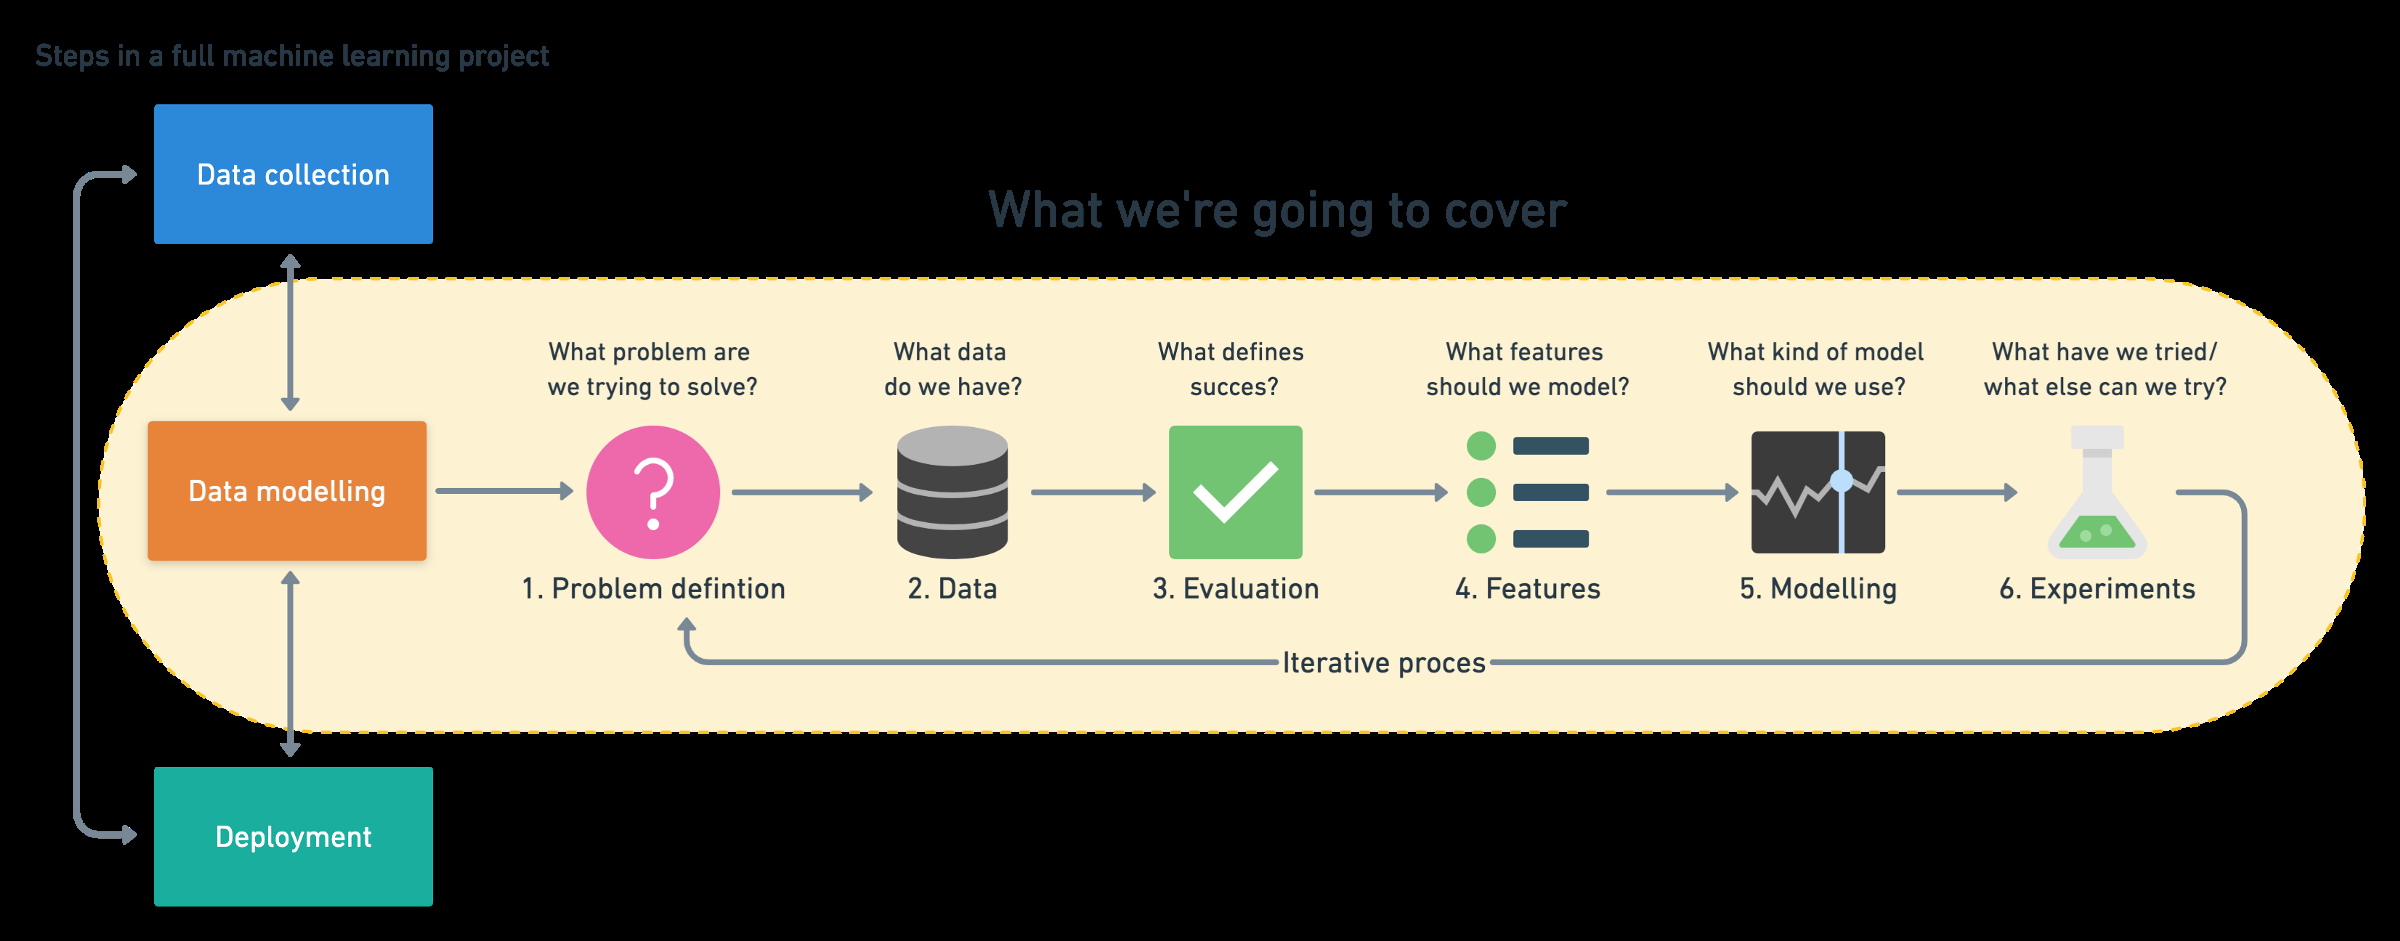





Pentru a parcurge schema din imagine am avut nevoie de cateva tool-uri clasice de **Data Science**, cum ar fi Pandas, NumPy, Matplotlib si Scikit-Learn pentru tehcnicile de modelare.

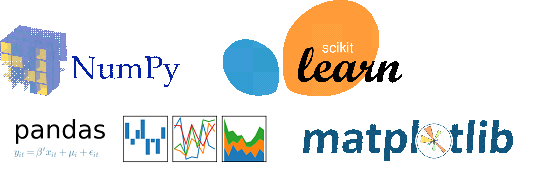

## 1. Definirea Problemei

Plecand de la datele cunoscute (istoricul de consum), incercam sa raspundem la intrebarea:
> Cat de bine putem prognoza consumul fiecarei instalatii, cunoscand consumul istoric?

## 2. Data

In ceea ce priveste Input-ul de date, exista 2 Input-uri, deoarece sunt 2 abordari de rezolvare a problemei:

1. Avand de a face cu o problema de tip `Regression`, intrucat trebuie sa determinam un numar, este bine cuonscut faptul ca modelarea de tip XGboost este cea mai eficienta pentru acest tip de probleme, am construit dataset-ul istoric aferent care contine:

    * Instalatia pentru care se face prognoza
    * Luna de consum
    * Ziua de consum, din saptamana
    * Sarbatoare sau nu
    * Consumul din ziua respectiva

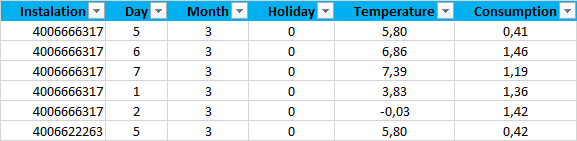

2. Din cauza neajunsurilor primei abordari, cea de a doua abordare este de tip Time Series, avand ca Input doar consumul istoric al instalatiilor:

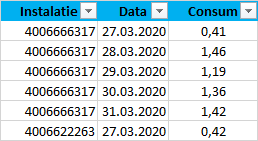

## 3. Evaluarea Modelelor

Avand de a face cu o problema de tip `Regression`, am utilizat pentru evaluarea modelelor 2 dintre valorile specifice acestui tip de problema:

* Modelarea XGBoost a fost evaluata cu RMSE (root mean squared error). Ca mentiune, am obtinut la aproximativ 26 de instalatii erori mai mari de 30 MWh.

* Acestea au fost corectate utilizand Time Series Forecasting, modelare evaluata prin MAE (mean absolute error), unde se obtin valori de obicei valori mai mici de 10 MWh.

## 4. Componentele datelor de intrare

Acestea reprezinta elementele caracteristice care compun Input-ul, caracteristic fiecarei instalatii modelate. In momentul de fata, acestea sunt:
* Instalatia pentru care se face prognoza
* Ziua din saptamana
* Luna
* Temperatura
* Consumul inregistrat

### Importarea datelor si pregatirea acestora pentru modelare

In [6]:
# Import data analysis tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
import openpyxl
import xlsxwriter
import xgboost as xgb
from sklearn.externals import joblib
from pathlib import Path
from sklearn.metrics import mean_squared_error
import os
from collections import OrderedDict
import seaborn as sns

new_data = pd.read_excel("New_Data_XGB.xlsx")
dataset = pd.concat([dataset, new_data]).drop_duplicates().reset_index(drop=True)
dataset = dataset.sample(frac = 1)

# Replace infs with nan
dataset.replace([np.inf, -np.inf], np.nan)

# Taking care of missing Data
dataset.dropna(inplace = True)

# Create unique list of Companies
Unique_Instalations = dataset.Instalation.unique()
# Create a data frame dictionary to store your data frames
Instalations_Dict = {elem : pd.DataFrame for elem in Unique_Instalations}

for inst in Instalations_Dict.keys():
    Instalations_Dict[inst] = dataset[:][dataset.Instalation == inst]

ModuleNotFoundError: No module named 'openpyxl'

In [7]:
# weekdays as a tuple
from datetime import date
import datetime
weekDays = ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")

# Check toaday's weekday
day = weekDays[date.today().weekday()]

if day == "Thursday":
    forecastData = pd.read_excel("forecastData_XGB_Saturday.xlsx")
elif day == "Friday":
    forecastData = pd.read_excel("forecastData_XGB_Tuesday.xlsx")
else:
    forecastData = pd.read_excel("forecastData_XGB.xlsx")

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

### 5.1 Modelarea XGBoost

In [ ]:
dict_models = {}
dict_predsVSreal = {}
dict_predsVSreal_v2 = {}
dict_rmse = {}
for inst in Unique_Instalations:
    if not os.path.isfile("./Models/%s.pkl" % inst):
        #Splitting the Variables
        X = Instalations_Dict[inst].iloc[:,1:5].values
        y = Instalations_Dict[inst].iloc[:,5].values
        
        if len(X) > 2:
                            
            # Split the dataset into trainig set and test set
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
            #y_train = np.nan_to_num(y_train)   
            if len(X_train) > 2:
                # Converting the dataset into optimized data strcture
                #    dtrain = xgb.DMatrix(X_train, label = y_train)
                #    dtest = xgb.DMatrix(X_test, label = y_test)
                    
                    # Transform to svmlight_file
                #    from sklearn.datasets import dump_svmlight_file
                #    dump_svmlight_file(X_train, y_train, "dtrain.svm", zero_based = True)
                #    dump_svmlight_file(X_test, y_test, "dtest.svm", zero_based = True)
                #    dtrain_svm = xgb.DMatrix("dtrain.svm")
                #    dtest_svm = xgb.DMatrix("dtest.svm")
                    
                # Building the Model and train it on the training set
                xgb_regressor = xgb.XGBRegressor(objective = "reg:linear", learning_rate = 0.1, max_depth = 5, subsample = 0.5, colsample_bytree = 0.3, n_estimators = 50, alpha =10)
                xgb_regressor.fit(X_train, y_train)
                
                # Applying GridSearch to chose the best parameters
                from sklearn.model_selection import GridSearchCV
                parameters_xgb = [{"eta": [0.05, 0.1, 0.15], 
                                   "max_depth": [5, 8],  
                                   "num_boosting_round": [30, 50],
                                   "subsample": [0.5, 0.8],
                                   "min_child_weight": [0.6, 0.8, 1]}]
                # Setting the CV 
                if len(X_train) < 10:
                    folds = len(X_train)
                else:
                    folds = 10
                grid_search_xgb = GridSearchCV(estimator = xgb_regressor,
                                           param_grid = parameters_xgb,
                                           cv = folds,
                                           n_jobs = -1)
                grid_search_xgb = grid_search_xgb.fit(X_train, y_train)
                best_score_xgb = grid_search_xgb.best_score_
                best_parameters_xgb = grid_search_xgb.best_params_
                
                # Train the model on the dataset with the best parameters
                regressor_xgb_best = xgb.XGBRegressor(objective = "reg:linear", 
                                                   eta = best_parameters_xgb["eta"], 
                                                   max_depth = best_parameters_xgb["max_depth"], 
                                                   subsample = best_parameters_xgb["subsample"], 
                                                   early_stopping_rounds = 10,
                                                   num_boosting_round = best_parameters_xgb["num_boosting_round"], 
                                                   seed = 123)
                                        
                regressor_xgb_best.fit(X_train, y_train)
                
                # Predicting the test set results
                preds_xgb = regressor_xgb_best.predict(X_test)
                xgb_rmse = np.sqrt(mean_squared_error(y_test, preds_xgb))
                dict_predsVSreal[inst] = {"preds_xgb": preds_xgb, "real values": y_test, "xgb_rmse": xgb_rmse}
                
                # Chosing the best model for each company
                dict_models[inst] = regressor_xgb_best
                
                # Saving the models
                for inst in dict_models.keys():
                    dict_models[inst].save_model("Models\%s.model" % inst)
                    joblib.dump(dict_models[inst], "Models\%s.pkl" % inst)
                
                # Export predsVSreal to Excel
                dict_predsVSreal_df = pd.DataFrame(data = dict_predsVSreal)
                dict_predsVSreal_df.to_excel("PredsVSReal.xlsx")
                
                                                
                                                # 3. RETRAIN THE MODELS WITH NEW DATA
                            
    elif len(Instalations_Dict[inst]) > 0 and inst in forecastData.Instalation.values:
        # Separate the Independent Variable
        X = Instalations_Dict[inst].iloc[:,1:5].values
        y = Instalations_Dict[inst].iloc[:,5].values
        
        if len(X) > 2:
            # Split the dataset into trainig set and test set
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)      
            # Loading the Model
            xgb_loaded = joblib.load("Models\%s.pkl" % inst)
    #        # Retrain the Model on new Data
            #params = {'objective': 'reg:linear', 'verbose': False, "eta": 0.05, "min_child_weight": 0.8, "warm_start": "False"}
            xgb_loaded.fit(X_train, y_train)
    #        # Predicting the values on the test set
            preds_xgb_v2 = xgb_loaded.predict(X_test)
            xgb_rmse_v2 = np.sqrt(mean_squared_error(y_test, preds_xgb_v2))
            dict_predsVSreal_v2[inst] = {"preds_xgb": preds_xgb_v2, "real values": y_test, "xgb_rmse": xgb_rmse_v2}
            # joblib.dump(xgb.loaded, "Models\%s.pkl" % inst)

# 4. SEPARATING AND SORTING THE INSTALATIONS AFTER RMSE

dict_predsVSreal_v2_descending = sorted(dict_predsVSreal_v2.items(), key = lambda x: x[1]["xgb_rmse"], reverse = True)
dict_inst_rmse = {}
instalations_rmse = np.array(dict_predsVSreal_v2_descending)
for i in range(len(instalations_rmse)):
    dict_inst_rmse[instalations_rmse[i][0]] = instalations_rmse[i][1]["xgb_rmse"]

instalations_rmse_descending = sorted(dict_inst_rmse.items(), key = lambda x: x[1], reverse = True)

# 5. PREDICT CONSUMPTION FOR EACH INSTALATION
           
# Predictions if today is Thursday
if day == "Thursday":
    # Predictions for Saturday:
    y_pred_instalations_Saturday = {}
    forecastData = pd.read_excel("forecastData_XGB_Saturday.xlsx")
    # Taking care of missing Data for forecastData
    forecastData.replace([np.inf, -np.inf], np.nan)
    forecastData.dropna(inplace = True)
    noModelsInstalations = []
    for inst in forecastData.Instalation.unique():
        if os.path.isfile("./Models/%s.pkl" % inst):
            xgb_loaded = joblib.load("Models\%s.pkl" % inst)
            y_pred_instalations_Saturday[inst] = xgb_loaded.predict(forecastData.iloc[:,1:5][forecastData.Instalation == inst].values)
        else:
            noModelsInstalations.append(inst)
    # Predictions for Sunday:
    y_pred_instalations_Sunday = {}
    forecastData = pd.read_excel("forecastData_XGB_Sunday.xlsx")
    # Taking care of missing Data for forecastData
    forecastData.replace([np.inf, -np.inf], np.nan)
    forecastData.dropna(inplace = True)
    noModelsInstalations = []
    for inst in forecastData.Instalation.unique():
        if os.path.isfile("./Models/%s.pkl" % inst):
            xgb_loaded = joblib.load("Models\%s.pkl" % inst)
            y_pred_instalations_Sunday[inst] = xgb_loaded.predict(forecastData.iloc[:,1:5][forecastData.Instalation == inst].values)
        else:
            noModelsInstalations.append(inst)
    # Predictions for Monday:
    y_pred_instalations_Monday = {}
    forecastData = pd.read_excel("forecastData_XGB_Monday.xlsx")
    # Taking care of missing Data for forecastData
    forecastData.replace([np.inf, -np.inf], np.nan)
    forecastData.dropna(inplace = True)
    noModelsInstalations = []
    for inst in forecastData.Instalation.unique():
        if os.path.isfile("./Models/%s.pkl" % inst):
            xgb_loaded = joblib.load("Models\%s.pkl" % inst)
            y_pred_instalations_Monday[inst] = xgb_loaded.predict(forecastData.iloc[:,1:5][forecastData.Instalation == inst].values)
        else:
            noModelsInstalations.append(inst)
            
# If today is Friday
elif day == "Friday":
    # Predictions for Tuesday:
    y_pred_instalations_Tuesday= {}
    forecastData = pd.read_excel("forecastData_XGB_Tuesday.xlsx")
    # Taking care of missing Data for forecastData
    forecastData.replace([np.inf, -np.inf], np.nan)
    forecastData.dropna(inplace = True)
    noModelsInstalations = []
    for inst in forecastData.Instalation.unique():
        if os.path.isfile("./Models/%s.pkl" % inst):
            xgb_loaded = joblib.load("Models\%s.pkl" % inst)
            y_pred_instalations_Tuesday[inst] = xgb_loaded.predict(forecastData.iloc[:,1:5][forecastData.Instalation == inst].values)
        else:
            noModelsInstalations.append(inst)

# If today it's not Thursday or Friday
else:
    # Predictions for Sunday:
    y_pred_instalations= {}
    forecastData = pd.read_excel("forecastData_XGB.xlsx")
    # Taking care of missing Data for forecastData
    forecastData.replace([np.inf, -np.inf], np.nan)
    forecastData.dropna(inplace = True)
    noModelsInstalations = []
    for inst in forecastData.Instalation.unique():
    #    if os.path.isfile("./Models/%s.model" % inst):
    #        predMatrix = xgb.DMatrix(forecastData.iloc[:,1:5][forecastData.Instalation == inst].values)
    #        y_pred_instalations[inst] = xgb_v2.predict(predMatrix)
        if os.path.isfile("./Models/%s.pkl" % inst):
            xgb_loaded = joblib.load("Models\%s.pkl" % inst)
            y_pred_instalations[inst] = xgb_loaded.predict(forecastData.iloc[:,1:5][forecastData.Instalation == inst].values)
        else:
            noModelsInstalations.append(inst)

### 5.2 Modelare Time Series - `LSTM`

In [ ]:
# 1. Loading the LSTM Bidirectional Data

new_data_TS = pd.read_excel("New_Data_TS.xlsx")
dataset_TS = pd.concat([dataset_TS, new_data_TS]).drop_duplicates().reset_index(drop=True)
#dataset_LSTM["Data"] = pd.to_datetime(dataset_LSTM.Data)
dataset_TS.replace([np.inf, -np.inf], np.nan)
dataset_TS.dropna(inplace = True)
#dataset_LSTM.sort_values(dataset_LSTM.Data, inplace = True)
# forecastData = pd.read_excel("forecastData.xlsx")
# Creating the dictionary of companies dataframes
# Create unique list of Companies
Unique_Instalations_TS = dataset_TS.Instalatie.unique()
# Create a data frame dictionary to store your data frames
Instalations_Dict_TS = {elem : pd.DataFrame for elem in Unique_Instalations_TS}
for inst in Instalations_Dict_TS.keys():
    Instalations_Dict_TS[inst] = dataset_TS.iloc[:, 1:3][dataset_TS.Instalatie== inst]

for inst in Instalations_Dict_TS.keys():
    Instalations_Dict_TS[inst]["Data"] = pd.to_datetime(Instalations_Dict_TS[inst]["Data"])
    Instalations_Dict_TS[inst].sort_values(by = ["Data"], inplace = True)
    Instalations_Dict_TS[inst].set_index("Data", inplace = True)
    
# 2. Extracting the Instalations to be modelled through LSTM

#dataset_LSTM = dataset_LSTM[dataset_LSTM.Data < "2020-02-09"]
#
## Creating the dictionary of companies dataframes
## Create unique list of Companies
#Unique_Instalations_LSTM = dataset_LSTM.Instalatie.unique()
#
## Create a data frame dictionary to store your data frames
#Instalations_Dict_LSTM = {elem : pd.DataFrame for elem in Unique_Instalations_LSTM}
#for inst in Instalations_Dict_LSTM.keys():
#    Instalations_Dict_LSTM[inst] = dataset_LSTM.iloc[:, 1:3][dataset_LSTM.Instalatie== inst]
#
#for inst in Instalations_Dict_LSTM.keys():
#    df_inst = Instalations_Dict_LSTM[inst]
#    df_inst["Data"] = pd.to_datetime(df_inst.Data)
#    df_inst.sort_values(by = ["Data"], inplace = True)
#    df_inst = df_inst.set_index("Data", inplace = True)
    
LSTM_Instalations = []
for inst in forecastData.Instalation:
    if inst in dict_predsVSreal_v2.keys():
#        if Instalations_Dict_LSTM[inst][Instalations_Dict_LSTM[inst].index.month == 1].mean()[0] > 100:
        # Selecting the Instalations with rmse > 30
        if dict_predsVSreal_v2[inst]["xgb_rmse"] > 30:
            LSTM_Instalations.append(inst)
         
#LSTM_Instalations_splitate = []
#def split_LSTM_Instalations(instalations, n = 5):
#    for i in range(0, len(LSTM_Instalations), n):
#        LSTM_Instalations_splitate.append(LSTM_Instalations[i:i+n])
#split_LSTM_Instalations(LSTM_Instalations)

# 3. Creating, train and predict
    
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Bidirectional
from numpy import array
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# convert history into inputs and outputs
def split_sequence(train, n_input = 7, n_out = 7):
	# flatten data
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(train)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(train):
			x_input = train[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(train[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(test):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

n_features = 1
n_steps = 7

    
# 4. Predictions

predictions_Bidirectional = {}
for inst in LSTM_Instalations:
    if not os.path.isfile("Models_LSTM_Bidirectional_encoder-decoder\%s.h5" % inst) and inst in Instalations_Dict_TS.keys():
        values = Instalations_Dict_TS[inst].values.reshape(-1,1)
        values = values[int(-0.7*len(values)): len(values)]
        # Splitting dataset into train and test sets
        train_size = int(len(values) * 0.6)
        test_size = len(values) - train_size
        train, test = values[0:train_size, :], values[train_size: len(values), :]
        X_train, y_train = split_sequence(train, n_steps)
        X_test, y_test = split_sequence(test)
        y_train = y_train.reshape(y_train.shape[0], n_steps, n_features)
        
        # define model
        model = Sequential()
        model.add(Bidirectional(LSTM(200, activation='relu'), input_shape=(n_steps, n_features)))
        model.add(RepeatVector(7))
        model.add(Bidirectional(LSTM(200, activation = "relu", return_sequences = True)))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(1)))
        model.compile(loss='mse', optimizer='adam')
        
        # # fit the model
        model.fit(X_train, y_train, epochs = 10, verbose = 0)
        
        # make predictions on test set
        # predictions_test = {}
        # predictions_inst = []
        # scores = []
        # for i in range(len(X_test)):
        #     x_input = array(X_test[i])
        #     x_input = x_input.reshape(1, n_steps, n_features)
        #     yhat = model.predict(x_input)
        #     predictions_inst.append(yhat)
        # for i in range(len(X_test)):
        #     mse = mean_squared_error(y_test[i], predictions_inst[i].reshape(7))
        #     rmse = sqrt(mse)
        #     predictions_test["sample" + str(i)] = rmse
        #     predictions[inst] = predictions_test
        # # save model to single file
        model.save("Models_LSTM_Bidirectional_encoder-decoder\%s.h5" % inst)
    elif inst in Instalations_Dict_TS.keys() and inst not in predictions_Bidirectional.keys():
        values = Instalations_Dict_TS[inst].values.reshape(-1,1)
        values = values[int(-0.6*len(values)): len(values)]
#        # Splitting dataset into train and test sets
#        train_size = int(len(values) * 0.6)
#        test_size = len(values) - train_size
#        train, test = values[0:train_size, :], values[train_size: len(values), :]
#        X_train, y_train = split_sequence(train, n_steps)
#        X_test, y_test = split_sequence(test)
#        y_train = y_train.reshape(y_train.shape[0], n_steps, n_features)
        # load the model
        model = load_model("Models_LSTM_Bidirectional_encoder-decoder\%s.h5" % inst)
        # reshape from [samples, timesteps] into [samples, timesteps, features]
#        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
        # fit model
#        model.fit(X_train, y_train, epochs=10, verbose=0)
        # save model
#        model.save("Models_LSTM_Bidirectional_encoder-decoder\%s.h5" % inst)
        # make predictions
        x_input = array([values[-7:len(values)]])
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predictions_Bidirectional[inst] = yhat

### 5.3 Modelare Time Series - `AR`

In [ ]:
forecastData_TS = pd.read_excel("forecastData_TS.xlsx")

AR_Instalations = []
for inst in forecastData.Instalation:
     if inst in Instalations_Dict.keys() and len(Instalations_Dict[inst][Instalations_Dict[inst].Month == forecastData.Month.unique()[0]]) < 15:
         AR_Instalations.append(inst)
     if inst in noModelsInstalations:
         AR_Instalations.append(inst)
     if inst in dict_predsVSreal_v2.keys() and dict_predsVSreal_v2[inst]["xgb_rmse"] > 10:
         AR_Instalations.append(inst)
     if inst in Instalations_Dict_TS.keys() and inst in Instalations_Dict.keys() and len(Instalations_Dict[inst])<100:
         AR_Instalations.append(inst)

AR_Instalations_noXGB = []         
for inst in dataset_TS.Instalatie.unique():
    if inst not in dict_predsVSreal_v2.keys() and len(dataset_TS[(dataset_TS["Instalatie"] == inst) & (dataset_TS["Data"] == "{}".format(date.today()+datetime.timedelta(days=-3)))]) == 1:
        AR_Instalations_noXGB.append(inst)

from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import statistics

predictions_AR = {}
for inst in AR_Instalations:
    if inst in Instalations_Dict_TS and len(Instalations_Dict_TS[inst]) > 13:
        # split dataset
        X = Instalations_Dict_TS[inst].values
        if statistics.variance(X.reshape(len(X))) < 3:
            trend = "n"
        else:
            trend = "c"
        train, test = X[0:len(X)-7], X[len(X)-7:]
        # train autoregression
        model = AR(train)
        model_fit = model.fit(trend = trend)
#        print('Lag: %s' % model_fit.k_ar)
#        print('Coefficients: %s' % model_fit.params)
        # make predictions
        predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        for i in range(len(predictions_test)):
#        	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
            error = mean_squared_error(test, predictions_test)
            error_rmse = np.sqrt(error)
        model = AR(X)
        predictions = model.fit(trend = trend).predict(start = len(X), end = len(X) + 7, dynamic = False)
        predictions_AR[inst] = {"predictions": predictions, "rmse": error_rmse}
#print('Test RMSE: %.3f' % error_rmse)
# plot results
#pyplot.plot(test)
#pyplot.plot(predictions, color='red')
#pyplot.show()

predictions_AR_noXGB = {}
for inst in AR_Instalations_noXGB:
    if inst in Instalations_Dict_TS and len(Instalations_Dict_TS[inst]) > 13:
        # split dataset
        X = Instalations_Dict_TS[inst].values
        if statistics.variance(X.reshape(len(X))) < 3:
            trend = "n"
        else:
            trend = "c"
        train, test = X[0:len(X)-7], X[len(X)-7:]
        # train autoregression
        model = AR(train)
        model_fit = model.fit(trend = trend)
#        print('Lag: %s' % model_fit.k_ar)
#        print('Coefficients: %s' % model_fit.params)
        # make predictions
        predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        error = mean_squared_error(test, predictions_test)
        error_rmse = np.sqrt(error)
        model = AR(X)
        predictions = model.fit(trend = trend).predict(start = len(X), end = len(X) + 7, dynamic = False)
        predictions_AR_noXGB[inst] = {"predictions": predictions, "rmse": error_rmse}

### 5.4 Modelare Time Series - `AutoReg`

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

AutoReg_Instalations = []
for inst in forecastData.Instalation:
     if inst in Instalations_Dict.keys() and len(Instalations_Dict[inst][Instalations_Dict[inst].Month == forecastData.Month.unique()[0]]) < 15:
         AutoReg_Instalations.append(inst)
     if inst in noModelsInstalations:
         AutoReg_Instalations.append(inst)
     if inst in dict_predsVSreal_v2.keys() and dict_predsVSreal_v2[inst]["xgb_rmse"] > 10:
         AutoReg_Instalations.append(inst)
     if inst in Instalations_Dict_TS.keys() and inst in Instalations_Dict.keys() and len(Instalations_Dict[inst])<100:
         AutoReg_Instalations.append(inst)

AutoReg_Instalations_noXGB = []         
for inst in dataset_TS.Instalatie.unique():
    if inst not in dict_predsVSreal_v2.keys() and len(dataset_TS[(dataset_TS["Instalatie"] == inst) & (dataset_TS["Data"] == "{}".format(date.today()+datetime.timedelta(days=-3)))]) == 1:
        AutoReg_Instalations_noXGB.append(inst)

# Modelling for AutoReg_Instalations
predictions_AutoReg_noXGB = {}
for inst in AutoReg_Instalations_noXGB:
    if inst in Instalations_Dict_TS and len(Instalations_Dict_TS[inst]) > 13:
        # split dataset
        X = Instalations_Dict_TS[inst].values
        #        if statistics.variance(X.reshape(len(X))) < 1:
        #            trend = "n"
        #        else:
        #            trend = "c"
        train, test = X[0:len(X)-7], X[len(X)-7:]
        # train autoregression
        model = AutoReg(train, lags = 2, seasonal = True, period = 3, trend = "c")
        model_fit = model.fit()
        #        print('Lag: %s' % model_fit.k_ar)
        #        print('Coefficients: %s' % model_fit.params)
        # make predictions
        predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        error = mean_squared_error(test, predictions_test)
        error_rmse = np.sqrt(error)
        model = AutoReg(X, lags = 2, seasonal = True, period = 3, trend = "c")
        predictions = model.fit().predict(start = len(X), end = len(X) + 7, dynamic = False)
        predictions_AutoReg_noXGB[inst] = {"predictions": predictions, "rmse": error_rmse}

# Modelling for instalations that are not predicted with XGB
predictions_AutoReg = {}
for inst in AutoReg_Instalations:
    if inst in Instalations_Dict_TS and len(Instalations_Dict_TS[inst]) > 13:
        # split dataset
        X = Instalations_Dict_TS[inst].values
        #        if statistics.variance(X.reshape(len(X))) < 1:
        #            trend = "n"
        #        else:
        #            trend = "c"
        train, test = X[0:len(X)-7], X[len(X)-7:]
        # train autoregression
        model = AutoReg(train, lags = 2, seasonal = True, period = 3, trend = "c")
        model_fit = model.fit()
        #        print('Lag: %s' % model_fit.k_ar)
        #        print('Coefficients: %s' % model_fit.params)
        # make predictions
        predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        error = mean_squared_error(test, predictions_test)
        error_rmse = np.sqrt(error)
        model = AutoReg(X, lags = 2, seasonal = True, period = 3, trend = "c")
        predictions = model.fit().predict(start = len(X), end = len(X) + 7, dynamic = False)
        predictions_AutoReg[inst] = {"predictions": predictions, "rmse": error_rmse}

### 5.5 Modelare Time Series - `Prophet`

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py

Prophet_Instalations = []
for inst in forecastData.Instalation:
    if inst in dict_predsVSreal_v2.keys():
#        if Instalations_Dict_LSTM[inst][Instalations_Dict_LSTM[inst].index.month == 1].mean()[0] > 100:
        # Selecting the Instalations with rmse > 30
        if dict_predsVSreal_v2[inst]["xgb_rmse"] > 10:
            Prophet_Instalations.append(inst)
            
Instalations_Prophet_Dict = {}
for inst in Prophet_Instalations:
    if len(dataset_TS[dataset_TS.Instalatie == inst]) > 0:
        Instalations_Prophet_Dict[inst] = Instalations_Dict_TS[inst].reset_index()
        Instalations_Prophet_Dict[inst] = Instalations_Prophet_Dict[inst].rename(columns = {"Data":"ds", "Consum": "y"})

#for inst in Instalations_Dict_LSTM.keys():
#    if len(forecastData[forecastData["Instalation"] == inst]) == 0:
#        Instalations_Prophet_Dict[inst] = Instalations_Dict_LSTM[inst].reset_index()
#        Instalations_Prophet_Dict[inst] = Instalations_Prophet_Dict[inst].rename(columns = {"Data":"ds", "Consum": "y"})
        
predictions_Prophet = {}
for inst in Instalations_Prophet_Dict.keys():
    if len(Instalations_Prophet_Dict[inst]) > 2:
        m = Prophet()
        m.fit(Instalations_Prophet_Dict[inst])
        future = m.make_future_dataframe(periods = 7)
        predictions = m.predict(future)
        predictions_Prophet[inst] = predictions

### Writing the Predictions to Worksheet